# 直方图-2：直方图均衡

### 目标

在本节中,
- 我们将学习直方图均衡化的概念,并利用它来提高图像的对比度。

### 理论

考虑这样一个图像，它的像素值仅局限于某个特定的值范围。例如，较亮的图像将把所有像素限制在高值上。但是一幅好的图像会有来自图像所有区域的像素。因此，您需要将这个直方图拉伸到两端(如下图所示，来自wikipedia)，这就是直方图均衡化的作用(简单来说)。这通常会提高图像的对比度。

![](data/histogram_equalization.png)

我建议您阅读直方图均衡化上的Wikipedia页面，以获取有关它的更多详细信息。它很好地解释了示例，使您在阅读完之后几乎可以理解所有内容。相反，在这里我们将看到其Numpy实现。之后，我们将看到OpenCV功能。

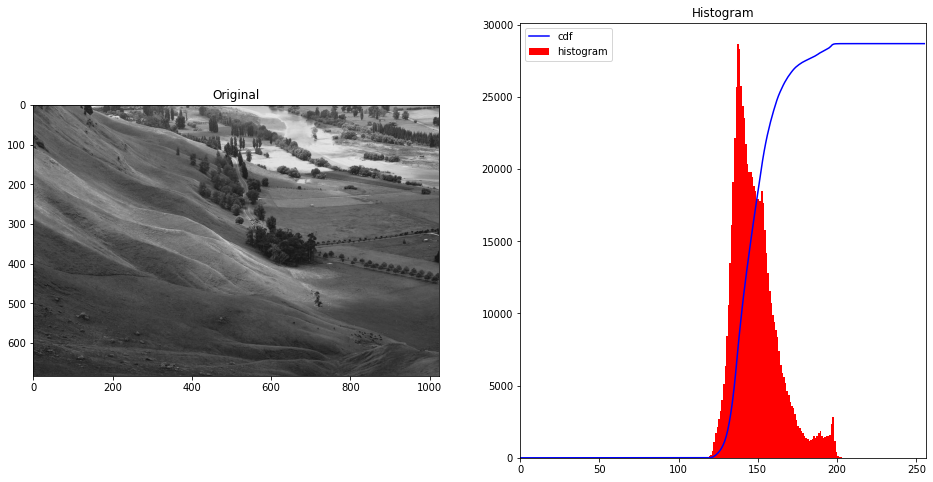

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/wiki.jpg',0)
hist,bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(img,'gray')
plt.title('Original')

plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title('Histogram')

plt.show()

你可以看到直方图位于较亮的区域。我们需要全频谱。为此，我们需要一个转换函数，将亮区域的输入像素映射到整个区域的输出像素。这就是直方图均衡化的作用。

现在我们找到最小的直方图值(不包括0)，并应用wiki页面中给出的直方图均衡化方程。但我在这里用过，来自Numpy的掩码数组概念数组。对于掩码数组，所有操作都在非掩码元素上执行。您可以从Numpy文档中了解更多关于掩码数组的信息。

In [2]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

现在我们有了查找表，该表为我们提供了有关每个输入像素值的输出像素值是什么的信息。因此，我们仅应用变换。

In [3]:
img2 = cdf[img]

现在，我们像以前一样计算其直方图和cdf（您这样做），结果如下所示：

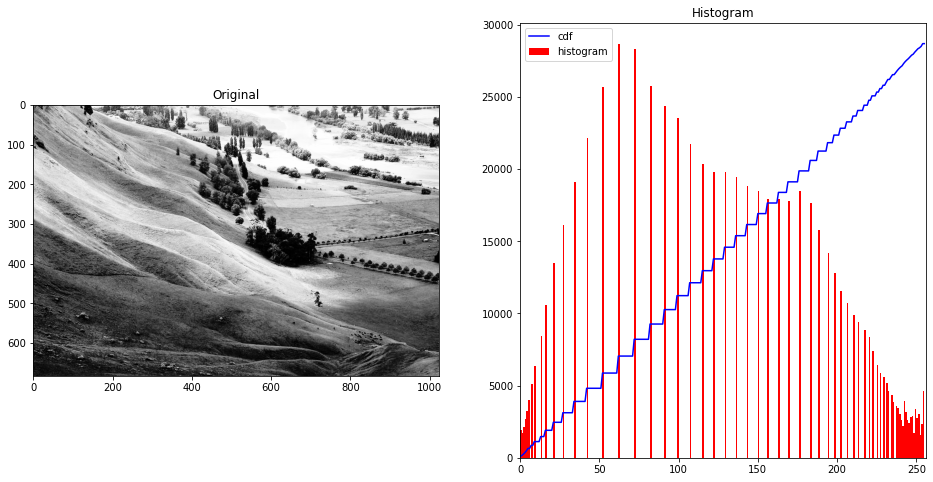

In [4]:
hist,bins = np.histogram(img2.flatten(),256,[0,256])

cdf = hist.cumsum()

cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(img2,'gray')
plt.title('Original')

plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.title('Histogram')

plt.show()

另一个重要的特征是，即使图像是一个较暗的图像(而不是我们使用的一个较亮的图像)，经过均衡后，我们将得到几乎相同的图像。因此，这是作为一个“参考工具”，使所有的图像具有相同的照明条件。这在很多情况下都很有用。例如，在人脸识别中，在对人脸数据进行训练之前，对人脸图像进行直方图均衡化处理，使其具有相同的光照条件。

### OpenCV中的直方图均衡

OpenCV具有执行此操作的功能cv.equalizeHist（）。它的输入只是灰度图像，输出是我们的直方图均衡图像。 下面是一个简单的代码片段，显示了它与我们使用的同一图像的用法：

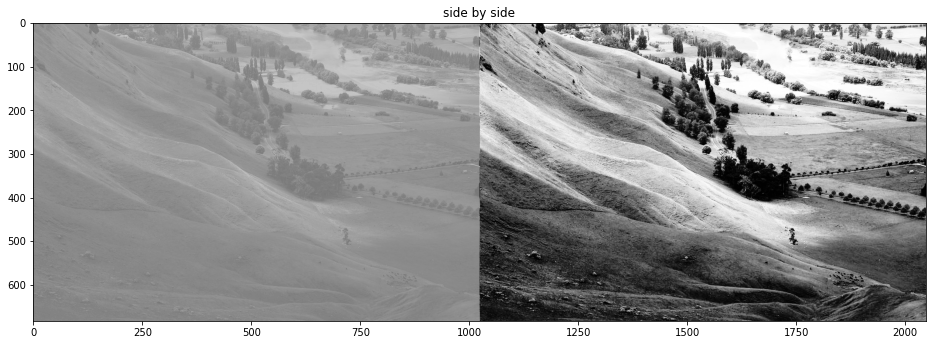

In [5]:
img = cv.imread('data/wiki.jpg',0)
equ = cv.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv.imwrite('output/res.png',res)

plt.figure(figsize=(16, 8))
plt.imshow(res,'gray')
plt.title('side by side')

plt.show()

因此，现在您可以在不同的光照条件下拍摄不同的图像，对其进行均衡并检查结果。

当图像的直方图限制在特定区域时，直方图均衡化效果很好。在直方图覆盖较大区域（即同时存在亮像素和暗像素）的强度变化较大的地方，效果不好。请检查其他资源中的SOF链接。

### CLAHE（对比度受限的自适应直方图均衡）

我们刚刚看到的第一个直方图均衡化考虑了图像的整体对比度。在许多情况下，这不是一个好主意。例如，下图显示了输入图像及其在全局直方图均衡后的结果。

![](data/clahe_1.jpg)


直方图均衡后，背景对比度确实得到了改善。但是在两个图像中比较雕像的脸。由于亮度过高，我们在那里丢失了大多数信息。这是因为它的直方图不像我们在前面的案例中所看到的那样局限于特定区域（尝试绘制输入图像的直方图，您将获得更多的直觉）。

因此，为了解决这个问题，使用了**自适应直方图均衡**。在这种情况下，图像被分成称为“tiles”的小块（在OpenCV中，tileSize默认为`8x8`）。然后，像往常一样对这些块中的每一个进行直方图均衡。因此，在较小的区域中，直方图将限制在一个较小的区域中（除非存在噪声）。如果有噪音，它将被放大。为了避免这种情况，应用了对比度限制。如果任何直方图bin超出指定的对比度限制（在OpenCV中默认为40），则在应用直方图均衡之前，将这些像素裁剪并均匀地分布到其他bin。均衡后，要消除图块边界中的伪影，请应用双线性插值。

下面的代码片段显示了如何在OpenCV中应用CLAHE： 

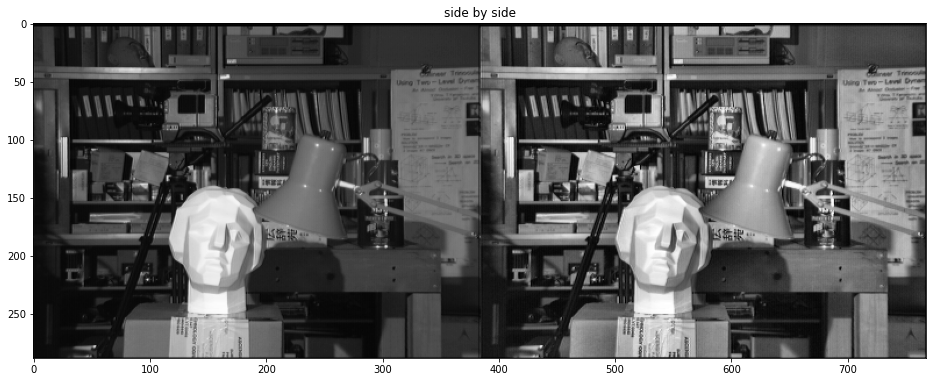

In [6]:
import numpy as np
import cv2 as cv

img = cv.imread('data/tsukuba_g.png',0)

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
cv.imwrite('output/clahe_2.jpg',cl1)

res = np.hstack((img,cl1)) #stacking images side-by-side

plt.figure(figsize=(16, 8))
plt.imshow(res,'gray')
plt.title('side by side')

plt.show()

### 附加资源

1. Wikipedia page on Histogram Equalization：http://en.wikipedia.org/wiki/Histogram_equalization
2. Masked Arrays in Numpy：http://docs.scipy.org/doc/numpy/reference/maskedarray.html

有关对比度调整的问题：`

1. 如何在C中的OpenCV中调整对比度？ http://stackoverflow.com/questions/10549245/how-can-i-adjust-contrast-in-opencv-in-c
2. 如何使用opencv均衡图像的对比度和亮度？http://stackoverflow.com/questions/10561222/how-do-i-equalize-contrast-brightness-of-images-using-opencv

### 练习